In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle
import astropy.units as u
import sunpy.map
from AntennaUtils import *  

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)

In [14]:
# RT32 location (Ventspils, Latvia)
rt32_antenna = RT32()
rt32_antenna.set_location(latitude=57.5535171694, longitude=21.8545525000, elevation=20)

# Define constants
path = ''
year = 2024
month = 2
day = 15
hour_start = 11
minute_start = 25

temperature = u.Quantity(15.5, unit=u.deg_C)
pressure = u.Quantity(1013.25, unit=u.hPa)
relative_humidity = u.Quantity(70.0, unit=u.percent)
obswl =u.Quantity(50000, unit=u.nm) 

weather = Weather(temperature, pressure, relative_humidity, obswl)

observation = SpiralSunObservation(weather,rt32_antenna , year , month , day , hour_start , minute_start)

az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositions()
observation.generateFile(path, az_anten , el_anten , utc)  

-------------------------------------------------------------
Saved:  sun_scan_240215_1125.ptf    3300   points


True

In [15]:
# Create DataFrame
sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1  })

fit_file_path = "lnsp4_5ch_240215_112029_122509.fit"
hdu_number = 1  # Number of the extension containing the binary table

# Converts the binary table to a Pandas DataFrame
data_df = bintable_to_pandas(fit_file_path, hdu_number)



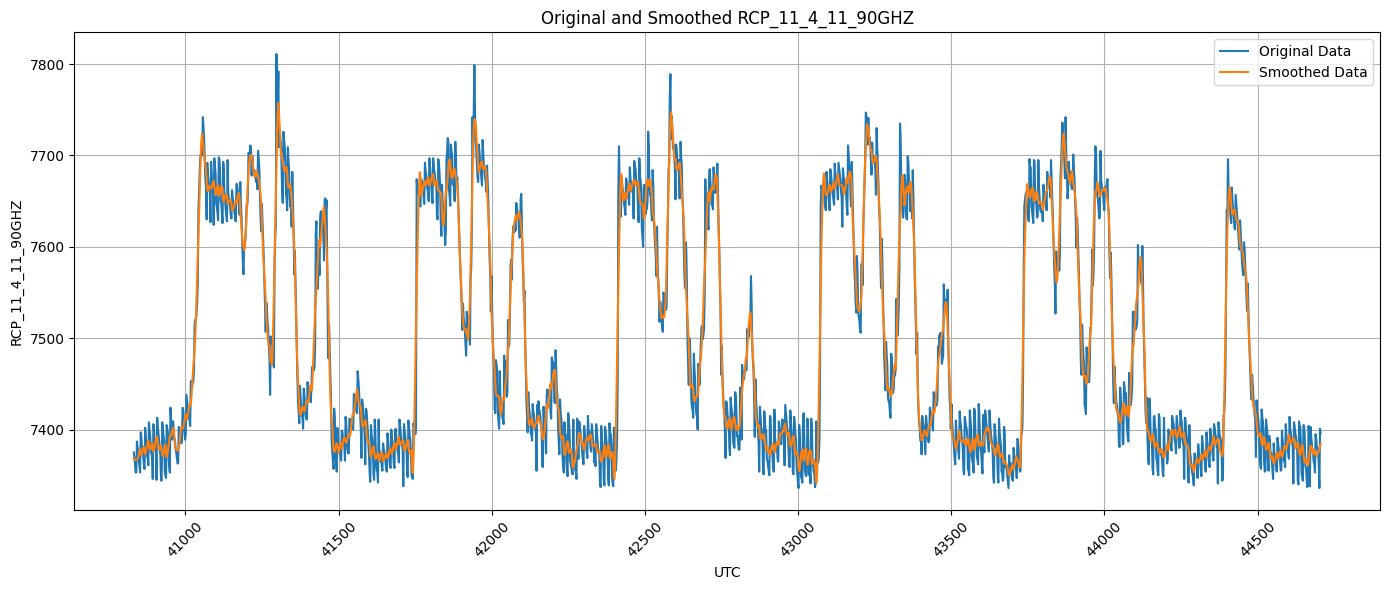

In [16]:
RCP_11_df = processData(data_df)

# Plotting both original and smoothed data
plt.figure(figsize=(14, 6))
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['RCP_11_4_11_90GHZ'], label='Original Data', linestyle='-')
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['Filtered_RCP_11_4_11_90GHZ'], label='Smoothed Data', linestyle='-')
plt.xlabel('UTC')
plt.ylabel('RCP_11_4_11_90GHZ')
plt.title('Original and Smoothed RCP_11_4_11_90GHZ')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
rest_of_df = getFinalProcessedData(observation , sunPositionDf,RCP_11_df)

print(rest_of_df.describe())

Interpolating data...
Filtering data...
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['RCP_11_4_11_90GHZ'] = (rest_of_df['RCP_11_4_11_90GHZ'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['Filtered_RCP_11_4_11_90GHZ'] = (rest_of_df['Filtered_RCP_11_4_11_90GHZ'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:440: S

                   UTC           SunX           SunY       UTC_RCP_11  \
count   685.0000000000 685.0000000000 685.0000000000   685.0000000000   
mean  42621.7556554745  -0.0153950958   0.0009694430 42621.7556554745   
std     937.6610367383   8.8961245505   8.8748498084   937.6610367383   
min   41160.4980000000 -19.5238252477 -19.7547100932 41160.4980000000   
25%   41891.6510000000  -6.7963605713  -6.7417137855 41891.6510000000   
50%   42622.5670000000   0.0255968612  -0.0078787593 42622.5670000000   
75%   43351.6580000000   6.6470205597   6.6315459279 43351.6580000000   
max   44082.5800000000  18.5499579078  19.0087584409 44082.5800000000   

       RCP_11_4_11_90GHZ  Filtered_RCP_11_4_11_90GHZ  
count     685.0000000000              685.0000000000  
mean        0.5264196462                0.5790362357  
std         0.2154189479                0.2431499393  
min         0.0635593220                0.0854680360  
25%         0.3326271186                0.3696533456  
50%         

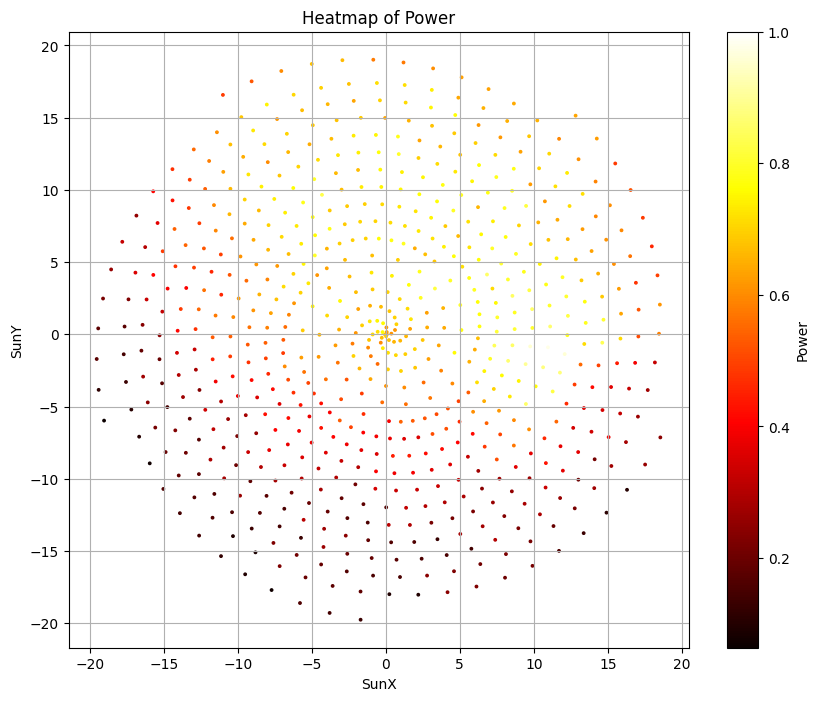

In [18]:
# Create the heatmap
plt.figure(figsize=(10, 8))
plt.scatter(rest_of_df['SunX'], rest_of_df['SunY'], c=rest_of_df['RCP_11_4_11_90GHZ'], cmap='hot',s=3)
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power')
plt.grid(True)  # Display the grid for clarity
plt.show()

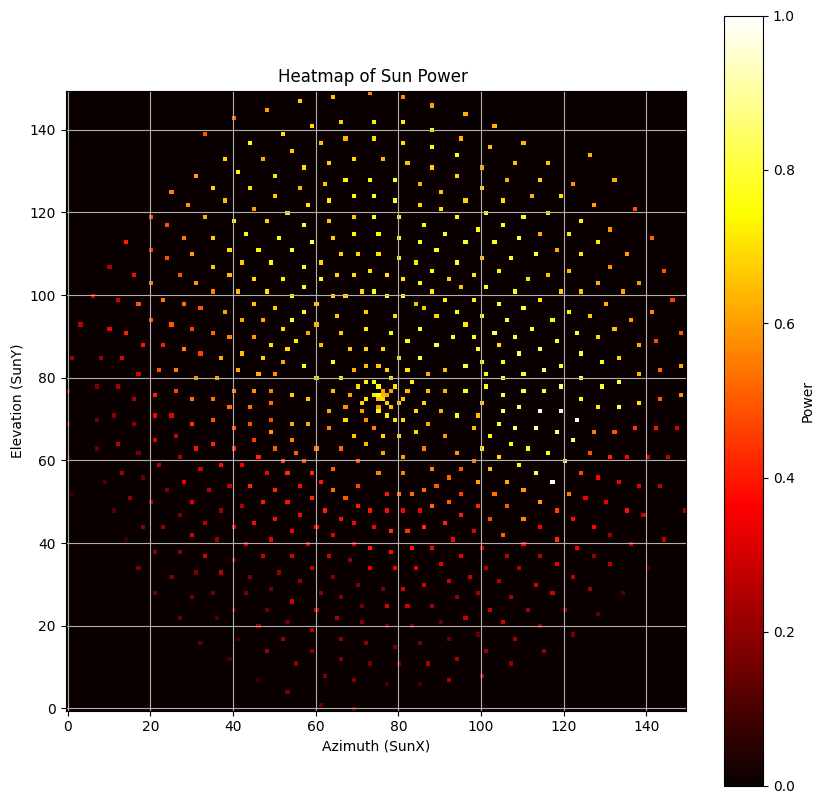

In [19]:
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']

# Define the size of the grid and create a matrix of zeroes
grid_size = 150
grid_power = np.zeros((grid_size, grid_size))

# Calculate the scale for converting SunX and SunY coordinates to matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convert SunX and SunY coordinates to matrix indices
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Assign Power values to the matrix in the corresponding positions
grid_power[grid_y_index, grid_x_index] = Power

# Show the image
plt.figure(figsize=(10, 10))
plt.imshow(grid_power, cmap='hot', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('Azimuth (SunX)')
plt.ylabel('Elevation (SunY)')
plt.title('Heatmap of Sun Power ')
plt.grid(True)  # Display the grid for clarity
plt.show()


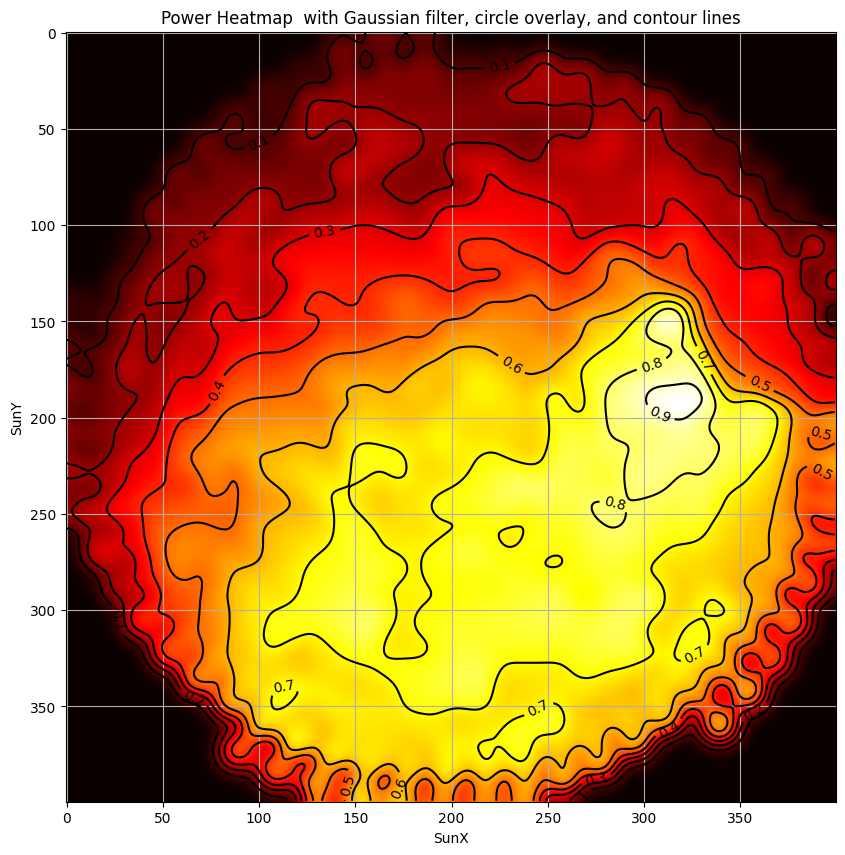

In [20]:
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']

# Define grid size and point radius
grid_size = 400
point_radius = 10

# Calculate scale to convert SunX and SunY coordinates to matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Create matrices for power and counts of points in each cell
Z = np.zeros((grid_size, grid_size))
counts = np.zeros((grid_size, grid_size))

# Iterate over each point and expand its power value in matrix Z
for x, y, power in zip(SunX, SunY, Power):
    i = int((x - x_min) / x_range * (grid_size - 1))
    j = int((y - y_min) / y_range * (grid_size - 1))
    
    y_indices, x_indices = np.ogrid[-j:grid_size-j, -i:grid_size-i]
    distances = np.sqrt(x_indices**2 + y_indices**2)
    
    indices_within_radius = np.where(distances <= point_radius)
    
    Z[indices_within_radius] += power
    counts[indices_within_radius] += 1

Z[counts > 0] /= counts[counts > 0]

# Apply Gaussian filter to matrix Z
Z_smoothed = gaussian_filter(Z, sigma=5)


# Create figure and axes
plt.figure(figsize=(10, 10))

# Plot smoothed heatmap
plt.imshow(Z_smoothed, cmap='hot')


# Add contour lines at values rounded to 0.1, 0.2, ..., 0.9
levels = np.arange(0.1, 1.0, 0.1)
contours = plt.contour(Z_smoothed, levels=levels, colors='black')

# Label the contours
plt.clabel(contours, inline=True, fmt='%.1f', fontsize=10)

# Adjust labels and title
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Power Heatmap  with Gaussian filter, circle overlay, and contour lines')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


In [21]:
print(rest_of_df.describe())



                   UTC           SunX           SunY       UTC_RCP_11  \
count   685.0000000000 685.0000000000 685.0000000000   685.0000000000   
mean  42621.7556554745  -0.0153950958   0.0009694430 42621.7556554745   
std     937.6610367383   8.8961245505   8.8748498084   937.6610367383   
min   41160.4980000000 -19.5238252477 -19.7547100932 41160.4980000000   
25%   41891.6510000000  -6.7963605713  -6.7417137855 41891.6510000000   
50%   42622.5670000000   0.0255968612  -0.0078787593 42622.5670000000   
75%   43351.6580000000   6.6470205597   6.6315459279 43351.6580000000   
max   44082.5800000000  18.5499579078  19.0087584409 44082.5800000000   

       RCP_11_4_11_90GHZ  Filtered_RCP_11_4_11_90GHZ  
count     685.0000000000              685.0000000000  
mean        0.5264196462                0.5790362357  
std         0.2154189479                0.2431499393  
min         0.0635593220                0.0854680360  
25%         0.3326271186                0.3696533456  
50%         

In [22]:
import pandas as pd
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord
from astropy.time import Time
from sunpy.coordinates import frames, sun

coordsXHelio = []
coordsYHelio = []

# Convert the array of times into a list of Time objects
times = [Time(t) for t in rest_of_df['isoT_time']]

# Calculate the sun's positions for each time in the list
az_sun = observation.sun_location.transform_to(AltAz(obstime=times, location=observation.antenna.location)).az.deg
el_sun = observation.sun_location.transform_to(AltAz(obstime=times, location=observation.antenna.location)).alt.deg

az_anten = az_sun + rest_of_df['SunX'] / np.cos(np.deg2rad(el_sun)) / 60.
el_anten = el_sun + rest_of_df['SunY'] / 60.    


rest_of_df['az_anten'] = az_anten
rest_of_df['el_anten'] = el_anten

# Iterar sobre los diferentes momentos de tiempo
for index, row in rest_of_df.iterrows():
    # Convert the AltAz coordinates from the DataFrame from degrees to radians
    el_deg = row['el_anten'] * u.deg
    az_deg = row['az_anten'] * u.deg

    # Set the observation time
    obstime = row['isoT_time']

    # Convertir a coordenadas heliocéntricas
    frame_altaz = AltAz(obstime=Time(obstime), location=observation.antenna.location)
    sun_helio = SkyCoord(alt=el_deg, az=az_deg, observer='earth' , distance=sun.earth_distance(obstime), frame=frame_altaz).transform_to(frames.Helioprojective)

    
    # Append the transformed coordinates to the list
    coordsXHelio.append(sun_helio.Tx.value)
    coordsYHelio.append(sun_helio.Ty.value)

rest_of_df['tx_helio_anten'] = coordsXHelio
rest_of_df['ty_helio_anten'] = coordsYHelio



In [23]:
print(rest_of_df.describe())



                   UTC           SunX           SunY       UTC_RCP_11  \
count   685.0000000000 685.0000000000 685.0000000000   685.0000000000   
mean  42621.7556554745  -0.0153950958   0.0009694430 42621.7556554745   
std     937.6610367383   8.8961245505   8.8748498084   937.6610367383   
min   41160.4980000000 -19.5238252477 -19.7547100932 41160.4980000000   
25%   41891.6510000000  -6.7963605713  -6.7417137855 41891.6510000000   
50%   42622.5670000000   0.0255968612  -0.0078787593 42622.5670000000   
75%   43351.6580000000   6.6470205597   6.6315459279 43351.6580000000   
max   44082.5800000000  18.5499579078  19.0087584409 44082.5800000000   

       RCP_11_4_11_90GHZ  Filtered_RCP_11_4_11_90GHZ       az_anten  \
count     685.0000000000              685.0000000000 685.0000000000   
mean        0.5264196462                0.5790362357 196.3586157914   
std         0.2154189479                0.2431499393   3.9605049200   
min         0.0635593220                0.0854680360 190.1

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


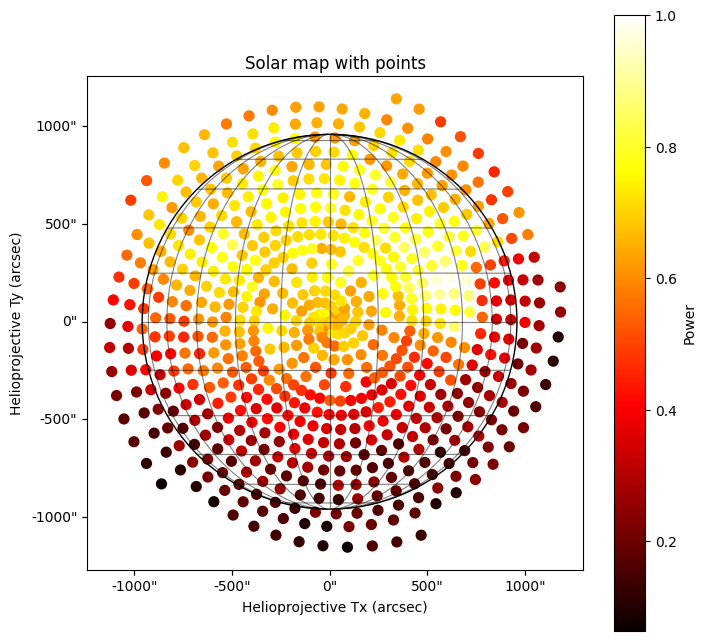

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map

# Supongamos que tienes un DataFrame llamado rest_of_df y tienes dos arrays de objetos coordsXHelio y coordsYHelio
# Definir las coordenadas x e y para los puntos (SunX y SunY)
SunX = rest_of_df['tx_helio_anten']
SunY = rest_of_df['ty_helio_anten']
Power = rest_of_df['RCP_11_4_11_90GHZ']  # Intensidad

# Definir metadatos para el mapa solar
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Ajusta esto a la fecha de observación correcta
    'crval1': 0,  
    'crval2': 0,  
    'cdelt1': 1,  
    'cdelt2': 1,  
    'cunit1': 'arcsec',  
    'cunit2': 'arcsec',  
    'ctype1': 'HPLN-TAN',  
    'ctype2': 'HPLT-TAN',  
    'crpix1': 0,  # No necesitamos esto si no estamos usando una matriz predefinida
    'crpix2': 0,  # No necesitamos esto si no estamos usando una matriz predefinida
    'waveunit': 'm',  
    'wavelnth': 0.0262897 * u.m,  
    'obsrvtry': 'Ventspils International Radio Astronomy Center',  
    'detector': 'LNSP4',  
    'dsun_obs': 1 * u.AU,  
    'hglt_obs': 0 * u.deg,  
    'hgln_obs': 0 * u.deg,  
}

# Crear un mapa solar en blanco con los metadatos
blank_map = sunpy.map.Map((np.zeros((10, 10)), metadata))

# Crear el gráfico
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=blank_map)
blank_map.plot(axes=ax)
blank_map.draw_limb(axes=ax, color="k")
blank_map.draw_grid(axes=ax, color="k")

# Plotear los puntos en el mapa
scatter = ax.scatter(SunX, SunY, c=Power, cmap='hot', s=50)

plt.colorbar(scatter,label='Power' , ax=ax) # Agregar barra de color para la intensidad
plt.title('Solar map with points')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()
